In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset, Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.maps import MapAxis
from gammapy.modeling.models.spectral import scale_plot_flux
from gammapy.estimators import FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 1MUXqVCD 

  Total counts                    : 361088 
  Total background counts         : 360331.31
  Total excess counts             : 756.96

  Predicted counts                : 361088.27
  Predicted background counts     : 360331.34
  Predicted excess counts         : 756.93

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752490.77

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

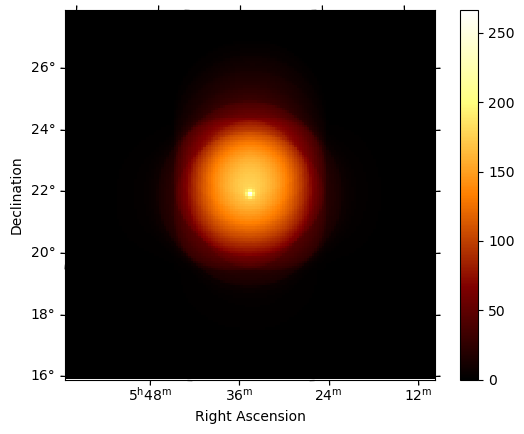

In [3]:
dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
# Create the spatial model 
model_spatial = GaussianSpatialModel(
    lon_0="83.631 deg",
    lat_0="22.018 deg",
    sigma="0.02 deg",
    )

# Create the spectral model 
model_spectrum  = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",
    lambda_="0.1 TeV-1")

# combine the spectral and the spatial model
source_model = SkyModel(spatial_model = model_spatial ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

# Create the model for the Background
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

# set the models in the dataset
dataset_asimov.models = models
# set counts
dataset_asimov.counts = dataset_asimov.npred()
    
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_asimov.geoms["geom"].width[1] / dataset_asimov.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_asimov)

## Varying the Exposure

In [4]:
shift = +0.085
tilt = 0.015

N = 35 #831
sigma_a = shift
sigma_i = tilt

save = True
save_flux = True

In [5]:
%%time
for n in range(N):
    try:
        print(n)
        shift_rnd = np.random.normal(0, shift, 1)
        tilt_rnd = np.random.normal(0, tilt, 1)
        #print(f"shift:, {shift_rnd}, tilt: {tilt_rnd}" )
        sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_rnd, 
                        tilt = tilt_rnd,
                        rnd = True)
        dataset = sys_d_cor.create_dataset()
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([dataset])


        if save:
            with open("data/7a_P_draw_info.txt", "a") as myfile:
                myfile.write(str(float(shift_rnd)) + '    '+ str(float(tilt_rnd)) + '    ' +  str(float(dataset.stat_sum())) + '\n')

        stri = ""
        for p in ['amplitude', 'index', 'lambda_', 'norm', 'tilt']:
            stri += str(dataset.models.parameters[p].value)  + '   ' +  str(dataset.models.parameters[p].error)  + '   '
        #print(stri)
        if save:
            with open("data/7a_P_draw_par.txt", "a") as myfile:
                myfile.write(stri + '\n')


        mask = dataset.mask.data[:,60,60]

        ebins = dataset.counts.geom.axes[0].center[mask]
        fluxes = []
        for e in ebins:
            flux =  dataset.models[0].spectral_model(e)
            fluxes.append(flux.value)

        ff = str()
        for f in fluxes:
            ff += str(f) + "  "
        #print(ff)
        if save:
            with open("data/7a_P_draw_flux.txt", "a") as myfile:
                myfile.write( ff + '\n')


        energy_bounds = (ebins[0], ebins[-1] ) * u.TeV

        energy_min, energy_max = energy_bounds
        energy = MapAxis.from_energy_bounds(
            energy_min,
            energy_max,
            18,
        )

        fluxe2, _ = dataset.models[0].spectral_model._get_plot_flux(sed_type='dnde', energy=energy)
        fluxe2 = scale_plot_flux(fluxe2, energy_power=2)
        fluxe2 = fluxe2.quantity[:, 0, 0]
        fluxe2 = np.array(fluxe2)   
        ff = str()
        for f in fluxe2:
            ff += str(f) + "  "
        if save:
            with open("data/7a_P_draw_flux2e.txt", "a") as myfile:
                myfile.write( ff + '\n')

        energy_edges = dataset.geoms['geom'].axes[0].edges
        esti  = FluxPointsEstimator(energy_edges= energy_edges)
        fluxpoints = esti.run([dataset])
        if save_flux:
            fluxpoints.write(f'data/fluxpoints/6_fluxpoints_{shift_rnd[0]:.6}.fits')
    except:
        pass

0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.33500928132389474 0.9126538306822568
norm 0.5528520382212013 0.3629138677056722
norm 1.3071125491581306 0.21407132930291492
norm 1.2578757711526232 0.1941203495221206
norm 0.7771303614917339 0.1916662341350631
norm 0.46500924612931527 0.19690256040997767
norm 1.3183507909984287 0.26345484327760077
norm 1.0756009230752694 0.3022470600650115
norm 0.9424323942011549 0.35231417594730063
norm 0.927964506589502 0.47123744503104237
norm 1.8546023027163865 0.735122442689493
norm 1.2238203801598733 1.02838754226302
norm 1.6045085059484452 1.7116411610462843
norm -2.9951496272144773 1.4526538670578357
norm 0.5900194138473946 5.272657623063168
norm -54.23168983906002 26.55979755972308
norm -36.41607650019599 23.201210718743045
norm 56.96319336710692 166.62668356333293
norm 1.0 0
1
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.8006872202553104 1.3215168009647273
norm 1.236978659336182 0.48723190398264615
norm 1.050995

norm 1.544212822830803 2.3754617833516267
norm -2.901846803321055 3.273629711005797
norm -3.2791711346460333 5.158339210392036
norm 4.920597231372787 21.95547969243099
norm 62.20893503280195 89.82296917446311
norm 1.0 0
10
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0003064867815508 1.1778063933271365
norm 0.7912791214527901 0.45756384878216544
norm 1.2472536305165496 0.2423427063903617
norm 0.7922411515131146 0.20210978024598963
norm 0.9286238296929461 0.21407006936457798
norm 1.2874835452200977 0.24079706012131016
norm 0.762326942964459 0.2542860975001303
norm 0.9206543462199361 0.30630794388678967
norm 1.439885890061179 0.40828724020145835
norm 0.432147916769923 0.44477155682483277
norm 1.2236385335861335 0.7097001452368954
norm 1.7946576365100975 1.219180289779219
norm 1.565193184675051 1.958747605968375
norm 0.17878651402434032 3.6448117080921136
norm -6.24746392386157 5.278787864202345
norm -33.97881197623506 16.05154964648587
norm -286.07873312833567 219.913097

norm 1.2273583358837434 0.4051493855714533
norm 0.3683769724381113 0.42001250410138924
norm 1.5457790758515433 0.6893846495185706
norm 1.8371409310713447 1.045678643650252
norm -1.0311481658434851 1.0969065049953908
norm 4.037246051870591 3.0745060490947096
norm -1.1537868570691343 4.7972743590672815
norm -4.598234175499803 9.740612252763492
norm -89.41141264570297 148.46605720421113
norm -5031.830785859348 1555.5460268349236
norm 1.0 0
20
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.9662272530559564 1.4040632364100654
norm 1.4657903630182287 0.5341421755352245
norm 0.9975357832043446 0.24686421500378933
norm 1.0161015942787444 0.20414471982603585
norm 0.7386555643342814 0.1961769898110855
norm 1.0796037371599698 0.21752132060998905
norm 1.1469436272840747 0.2375865539588812
norm 0.8760400635464357 0.24411562155479574
norm 0.6065004233413314 0.27085912102775694
norm 1.70347936798552 0.39395804632660597
norm 1.0955524657192142 0.4743706348217437
norm 1.1671082546707023 

norm 1.1557740762425546 0.1714060589030993
norm 0.7468687011239095 0.18819920797877945
norm 0.835525128936071 0.2201031941610424
norm 0.7304659091340612 0.2714785035522635
norm 1.7391057234903022 0.3828608533645628
norm 1.1541070014407075 0.4591595267797638
norm 0.6829520337138165 0.5437224575050978
norm 0.8082446430337692 0.7329086393641175
norm 1.3695267638310946 1.0506361875512953
norm 1.5125960256623747 1.4314103836999372
norm 1.1916724915169337 2.0309110766135037
norm 0.06405800032442592 2.4430663422530965
norm 1.5590740262056588 4.52097161492574
norm 2.175469484208824 5.581556658327793
norm -10.405713401943673 27.196280997386182
norm 1.0 0
30
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.4081720862275833 1.2711957207327116
norm 0.8177055202520486 0.43388304586476356
norm 1.1083040542128815 0.21624678966955335
norm 0.9976702284880483 0.18162675173460135
norm 0.8164366599953798 0.17875422974960295
norm 1.0525203855135803 0.19639416298623483
norm 1.045211022889379 0.